# 데이터 다운로드

In [1]:
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1
w = !apt install tree
print(w[-2])

Setting up tree (2.0.2-1) ...


In [2]:
# 샘플 데이터 다운로드
w = !wget -nc https://download.pytorch.org/tutorial/hymenoptera_data.zip

print(w[-2])

2025-03-22 01:48:38 (179 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]


In [3]:
# 데이터 압축 해제
w = !unzip -o hymenoptera_data.zip

print(w[-1])

  inflating: hymenoptera_data/val/bees/abeja.jpg  


In [4]:
# 압축 해제한 파일의 트리 구조 출력
!tree hymenoptera_data

hymenoptera_data
├── train
│   ├── ants
│   │   ├── 0013035.jpg
│   │   ├── 1030023514_aad5c608f9.jpg
│   │   ├── 1095476100_3906d8afde.jpg
│   │   ├── 1099452230_d1949d3250.jpg
│   │   ├── 116570827_e9c126745d.jpg
│   │   ├── 1225872729_6f0856588f.jpg
│   │   ├── 1262877379_64fcada201.jpg
│   │   ├── 1269756697_0bce92cdab.jpg
│   │   ├── 1286984635_5119e80de1.jpg
│   │   ├── 132478121_2a430adea2.jpg
│   │   ├── 1360291657_dc248c5eea.jpg
│   │   ├── 1368913450_e146e2fb6d.jpg
│   │   ├── 1473187633_63ccaacea6.jpg
│   │   ├── 148715752_302c84f5a4.jpg
│   │   ├── 1489674356_09d48dde0a.jpg
│   │   ├── 149244013_c529578289.jpg
│   │   ├── 150801003_3390b73135.jpg
│   │   ├── 150801171_cd86f17ed8.jpg
│   │   ├── 154124431_65460430f2.jpg
│   │   ├── 162603798_40b51f1654.jpg
│   │   ├── 1660097129_384bf54490.jpg
│   │   ├── 167890289_dd5ba923f3.jpg
│   │   ├── 1693954099_46d4c20605.jpg
│   │   ├── 175998972.jpg
│   │   ├── 178538489_bec7649292.jpg
│   │   ├── 1804095607_0341701e1c.jpg
│   │   

# 공통함수 불러오기

In [5]:
# 공통 함수 다운로드
!git clone https://github.com/wikibook/pythonlibs.git

# 공통 함수 불러오기
from pythonlibs.torch_lib1 import *

# 공통 함수 확인
print(README)

Cloning into 'pythonlibs'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 25 (delta 6), reused 25 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (25/25), 21.10 MiB | 15.81 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Common Library for PyTorch
Author: M. Akaishi


In [6]:
# GPU 디바이스 할당

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Transforms 정의

In [7]:
# 파이토치 관련 라이브러리
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# 검증 데이터 : 정규화
# 사전 학습 모델은 입력 데이터의 해상도가 224 화소인 데이터로 학습되어있음.
# 화면 전체를 256x256으로 Resize한 다음, 중앙의 224x224 부분을 CenterCrop
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# 훈련 데이터 : 정규화에 반전과 RandomErasing 추가
# 224x224 화소의 데이터를 반환하나, Resize와 이미지를 도려내는 위치에 난수 요소가 도입되어 있어, 데이터 증강의 효과
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

# ImageFolder 사용

In [10]:
# 베이스 디렉터리
data_dir = 'hymenoptera_data'

# 훈련 데이터 디렉터리와 검증 데이터 디렉터리 지정
import os
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'val')

print(train_dir, test_dir)

# 분류하려는 클래스의 리스트 작성
classes = ['ants', 'bees']

hymenoptera_data/train hymenoptera_data/val


# 데이터셋 정의

In [11]:
# 데이터셋 정의

# 훈련용
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
# 훈련 데이터 이미지 출력용
train_data2 = datasets.ImageFolder(train_dir, transform=test_transform)
# 검증용
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

In [12]:
# 데이터 건수 확인
print(f'훈련 데이터: {len(train_data)} 건')
print(f'검증 데이터: {len(test_data)} 건')

훈련 데이터: 244 건
검증 데이터: 153 건


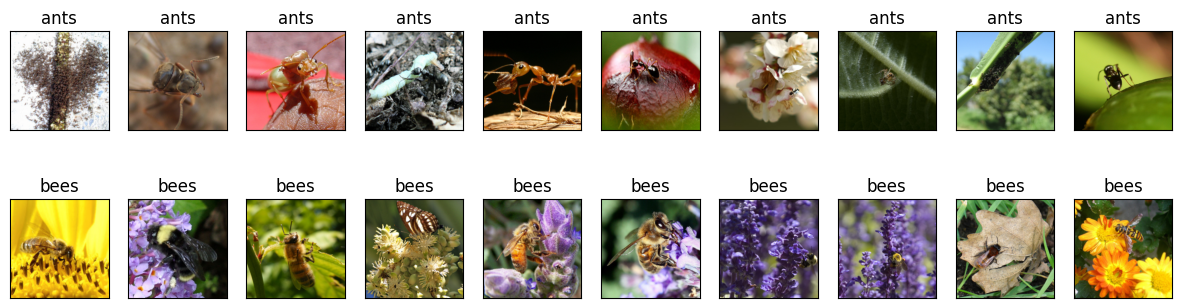

In [13]:
# 검증 데이터
# 처음 10개와 마지막 10개 이미지 출력

plt.figure(figsize=(15, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    image, label = test_data[i]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1)/2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 10, i + 11)
    image, label = test_data[-i-1]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1)/2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# 데이터로더 정의

In [14]:
batch_size = 10

# 훈련용
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# 검증용
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# 이미지 출력용
train_loader2 = DataLoader(train_data2, batch_size=50, shuffle=True)
test_loader2 = DataLoader(test_data, batch_size=50, shuffle=True)

In [15]:
torch_seed()
show_images_labels(test_loader2, classes, None, None)

Output hidden; open in https://colab.research.google.com to view.

# 파인 튜닝의 경우

In [17]:
# 사전 학습 모델 불러오기
# VGG-19-BN 모델을 학습이 끝난 파라미터와 함께 불러오기
from torchvision import models
net = models.vgg19_bn(pretrained = True)

# 난수 고정
torch_seed()

# 최종 노드의 출력을 2로 변경
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, 2)

# AdaptiveAvgPool2d 함수 제거
net.avgpool = nn.Identity()

# GPU 사용
net = net.to(device)

# 학습률
lr = 0.001

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()

# 최적화 함수 정의
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# history 파일도 동시에 초기화
history = np.zeros((0, 5))

In [18]:
# 학습
num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/5], loss: 0.04389 acc: 0.78689 val_loss: 0.01117, val_acc: 0.96078


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2/5], loss: 0.01904 acc: 0.93033 val_loss: 0.01269, val_acc: 0.96732


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3/5], loss: 0.02183 acc: 0.91803 val_loss: 0.01169, val_acc: 0.96732


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4/5], loss: 0.01476 acc: 0.93443 val_loss: 0.01714, val_acc: 0.95425


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5/5], loss: 0.01611 acc: 0.92623 val_loss: 0.01185, val_acc: 0.95425


# 전이 학습의 경우

In [19]:
# 사전 학습 모델 불러오기
# VGG-19-BN 모델을 학습이 끝난 파라미터와 함께 불러오기
from torchvision import models
net = models.vgg19_bn(pretrained = True)

# 모든 파라미터의 경사 계산을 OFF로 설정
for param in net.parameters():
  param.requires_grad = False

# 난수 고정
torch_seed()

# 최종 노드의 출력을 2로 변경
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, 2)

# AdaptiveAvgPool2d 함수 제거
net.avgpool = nn.Identity()

# GPU 사용
net = net.to(device)

# 학습률
lr = 0.001

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()

# 최적화 함수 정의
# 파라미터 수정 대상을 최종 노드로 제한
optimizer = optim.SGD(net.classifier[6].parameters(), lr=lr, momentum=0.9)

# history 파일도 동시에 초기화
history = np.zeros((0, 5))

In [20]:
# 학습
num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/5], loss: 0.04619 acc: 0.78279 val_loss: 0.01374, val_acc: 0.96078


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2/5], loss: 0.02254 acc: 0.91803 val_loss: 0.01268, val_acc: 0.96078


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3/5], loss: 0.02458 acc: 0.90164 val_loss: 0.01182, val_acc: 0.95425


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4/5], loss: 0.02029 acc: 0.90164 val_loss: 0.01274, val_acc: 0.95425


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5/5], loss: 0.02134 acc: 0.88934 val_loss: 0.01191, val_acc: 0.96078


In [21]:
# 난수 고정
torch_seed()

# 검증 데이터를 사용한 결과 출력
show_images_labels(test_loader2, classes, net, device)

Output hidden; open in https://colab.research.google.com to view.